<div style="background-color:powderblue;"><h1>Projet Synthese</h1><br><b>Groupe 3: Amardeepkumar Haulkhory, Hilaire Yuma, Jian-Guo Zhao, Mamadou Sy</b></div>

<h2>Partie II Apprentissage par <abbr title="Convolutional Neural Networks"><b>CNN </b></abbr></h2>
<p>Definir le <abbr title="Convolutional Neural Networks"><b>CNN </b></abbr>architecture:</p>
<ol>
<li>La premiere couche, Conv2D, prend un batch de donnees avec input_shape=(48,48,1)</li>
<li>La deuxieme couche, Conv2D, prend la sortie de couche 1, keras determine le shape automatiquement</li>
    <li>Il n'est pas necessaire d'indiquer input_shape pour les couches plus profondes</li>
    <li>La troisieme couche, Conv2D, prend la sortie de la couche 2, keras determine le shape automatiquement</li>
    <li>Ainsi de suite, on peut ajouter autres couches Conv2D s'il y en a besoin</li>
    <li>Entre chaque deux couches Conv2D, une couche Max pooling, taille (2,2), est ajoutee, pour bonne apprentissage</li>
    <li>Pour reduire le sur-apprentissage, une couche de regularisation Dropout pourrait aussi etre ajoutee</li>
    <li>Pour une meilleur performance, une couche Normalisation pourrait etre aussi appliquee</li>
<li>Avant la couche dense, nous allons ajouter une couche Flatten qui convert le matrix 2D en vector 1D</li>
    <li>Puis, une couche Dense avec une fonction activation ReLu</li>
    <li>Encore une couche de regularization Dropout est appliquee</li>
    <li>Enfin, la couche de sortie donne 7 neurons pour les 7 classes avec une fonction activation softmax qui donne la possibilite de prediction pour chaque class.</li>
</ol>

<h3>Dependences - packages nécessaires</h3>
<p>En utilisant <b>tensorflow.compat.v1</b>, vous devez desactiver eager_execution.<br>Ce n'est pas le cas pour <b>tensorflow.v2</b>. De plus, le package <b>tensorflow</b> n'a pas la fonction <b><i>disable_eager_execution</i></b>.</p>

In [29]:
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_eager_execution()

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D 
from keras.utils import to_categorical

import numpy as np      # linear algebra
import pandas as pd     # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import os
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from numpy import expand_dims
from keras.preprocessing.image import img_to_array

In [2]:
%matplotlib inline

<h3>Chargement des donnees</h3>
<p>Pour eviter l'operation <b>download</b> des donnees se fait chaque fois, on les sauvegarde dans un repertoire local, qui est differente pour different colaborateurs. Veuillez changez la valeur de variable <b><i>data_dir</i></b> si necessaire</p>

In [3]:
# download the data from web and saved to local directory
# put the data in a variable make the following code usable for any data sources
# Original data is hold by df
data_dir = "C:\\Users\\jeang\\Documents\\BDEB\\A62\\ProSyn3\\data\\fer2013.csv"
df = pd.read_csv(data_dir )

<h3>Repartition des donnees</h3>
<p>Les donnees originales sont repartie en trois partie. Selons Partie I, la cible est bien balance dans ces trois parties</p>

In [4]:
df_training = df[df['Usage']=='Training']
df_PublicTest = df[df['Usage']=='PublicTest']
df_PrivateTest = df[df['Usage']=='PrivateTest']

<h3>Fonction de transformation des données</h3>
<p><ul> La fonction <b><i>fer2013_to_4d_array</i></b> prend comme entree une dataframe qui tienne les donnees d'images en format des chaines de caracteres.<br>Elle retoune comme sortie un <b>np.array</b> de <mark>4 dimensions</mark>, normalisee, utilisables comme entree pour <b>tensorflow CNN<b></ul></p>

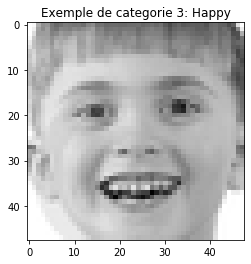

In [9]:
#import numpy as np
#import matplotlib.pyplot as plt

FER2013_WIDTH = 48
FER2013_HEIGHT = 48

# indices 0 - 6 correspondent emotions suivantes
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]  

def string_to_image(str_in):
    return np.reshape(str_in.split(" "), (FER2013_WIDTH, FER2013_HEIGHT)).astype("float")

def fer2013_show_instance(index, d=df):
    """Shows the image and the emotion label of the index's instance."""
    category, str_image = d.at[index,'emotion'], d.at[index,'pixels']
    image = string_to_image(str_image)
    plt.imshow(image, cmap="gray")
    plt.title(f"Exemple de categorie {category}: {Emotions[category]}")
    
fer2013_show_instance(np.random.randint(0,len(df_training)))

In [10]:
def fer2013_to_4d_array(d=df):
    """Transforms the (blank separated) pixel strings in the DataFrame to an 4-dimensional array 
    (1st dim: instances, 2nd and 3rd dims represent 2D image, 4th dim represent the color)."""
    
    pixels_list = d["pixels"].values
    list_image_2d = [string_to_image(pixels) for pixels in pixels_list]
        
    # Convert list to 4D array:
    X = np.expand_dims(np.array(list_image_2d), -1)
    print(f"The given data <pixel strings> has been converted to {X.shape} array")
    
    return X / 255

<p>On applique la fonction <b><i>fer2013_to_4d_array</i></b> sur les trois partitions</P>

In [11]:
X_train = fer2013_to_4d_array(df_training)
X_test = fer2013_to_4d_array(df_PrivateTest)
X_valid = fer2013_to_4d_array(df_PublicTest)

The given data <pixel strings> has been converted to (28709, 48, 48, 1) array
The given data <pixel strings> has been converted to (3589, 48, 48, 1) array
The given data <pixel strings> has been converted to (3589, 48, 48, 1) array


<h3>Fonction de transformation pour la cible</h3>
<p><ul>
    <li>La fonction <b style="backgroud-color:powerblue"><i>one_hot_label</i></b> prend comme entree une dataframe qui tienne les donnees d'emotions en format categoriel (7 classes).<br>Elle retoune comme sortie un <b>np.array</b> de <mark>2 dim</mark>. Les classes sont reparties en 7 colonnes, une pour chaque, utilisables pour <b>tensorflow<b></li>
    <li><b><mark>keras.utils.to_categorical</mark></b> peut faire le meme travail la sortie est du dtype float32</li>
</ul></p>

In [22]:
CLASS_NUMBER = 7
Y_train = to_categorical(df_training.emotion, CLASS_NUMBER)
Y_test = to_categorical(df_PrivateTest.emotion, CLASS_NUMBER)
Y_valid = to_categorical(df_PublicTest.emotion, CLASS_NUMBER)
Y_train[:5]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

<h3>Fonction <i>show_confusion_matrix</i></h3>
<p><ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>show_confusion_matrix</i></b> prend comme entree un modele</li>
    <li>Elle appelle la fonction <i style="color:blue">sklearn.metrics.confusion_matrix</i> en utilisant les donnees dans TestSet</li>
<li>pour retoune comme sortie un <b>pandas.DataFrame</b></li>
    </ul></p>

In [13]:
def show_confusion_matrix(model):
    submission = pd.DataFrame(model.predict(X_test))
    submission['label'] = submission.idxmax(axis=1)
    # y_pred = submission['label']
    # y_real = df_PrivateTest['emotion']
    cm = confusion_matrix(submission['label'], df_PrivateTest['emotion'])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = cm.round(2)
    return pd.DataFrame(cm)

<h3>Fonction <i>save_model</i></h3>
<p><ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>save_model</i></b> prend comme entree un modele</li>
<li>Elle appelle <i style="color:blue">keras.models.to_json</i> et <i style="color:blue">keras.models.save_weights</i></li>
<li>Puis sauvegarde le modele et les poids dans deux fichies dont les nom sont fournies par utilisateur</li>
<li>Si soit le nom de fichier, soit le nom du repertoire, non fournie, elle utilise un nom par defaut</li>
    </ul></p>

In [14]:
def save_model(model, file_json="", file_weight="", workdir=""):
    # serialize model to JSON
    model_json = model.to_json()
    projet_dir = workdir if len(workdir)>0 else "C:\\Users\\jeang\\Documents\\BDEB\\A62\\ProSyn3"
    model_filename = 'fer.json' if file_json=="" else file_json
    with open(os.path.join(projet_dir, model_filename), "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    # model.save_weights("C:\\Users\\Nisha Haulkhory\\projet de synthese\\GIT\\ProSyn3\\fer.h5")
    weight_filename = 'fer.h5' if file_weight=="" else file_weight
    model.save_weights(os.path.join(projet_dir, weight_filename))
    print("Saved model to disk done")

<h3>Fonction <i>get_model_v10</i></h3>
<p><ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>get_model_v10</i></b> peut prendre seulement quelques hyperparametres</li>
<li>Elle appelle <i style="color:blue">keras.models.Sequential</i> qui nous permet avec les hyperparametres de construire un cnn</li>
<li>Les valeurs par defaut sont notre choix entre les meilleures en ce moment, mais ceci vous donne la possibilite de les choisir</li>
<li>Elle retourne un architecture d'un modele Sequential qu'on peut l'entrainner et le tester</li>
    </ul></p>

In [18]:
def get_model_v10(num_layers=5, num_filtre=(512, 128, 64, 64, 32), k_size=3, p_size=(2, 2), dropout=0.25):
    input_shape = (48, 48, 1)
    model = Sequential()
    for layer in range(num_layers): 
        if layer == 0:
            model.add(Conv2D(num_filtre[layer], kernel_size=k_size, activation=tf.nn.relu, padding="same", input_shape=input_shape))
        else:
            model.add(Conv2D(num_filtre[layer], kernel_size=k_size, activation=tf.nn.relu, padding="same"))
        model.add(MaxPooling2D(pool_size=p_size))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Flatten())                          # Flattening the 2D arrays for fully connected layers
    model.add(Dense(32, activation=tf.nn.relu))
    model.add(Dropout(dropout))
    model.add(Dense(7,activation=tf.nn.softmax))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

<h3>Fonction <i>fit_test_save_model</i></h3>
<p><ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>fit_test_save_model</i></b> prend comme entree un modele cnn et quelques hyperparametres</li>
<li>Elle appelle <i style="color:blue">keras.models.Sequential.fit</i> pour apprendre le modele cnn</li>
    <li>Elle affiche l'evolution d'apprentissage en utilisant <i style="color:blue">seaborn.lineplot</i></li>
<li>Puis, elle appelle <i style="color:blue">keras.models.Sequential.evaluate</i> pour tester le modele
<li>Les valeurs par defaut vous donne la possibilite de les choisir</li>
<li>Elle retourne None, l'histoire d'apprentissage du modele et le resultat du test ne sont pas utilisables</li>
    </ul></p>

In [19]:
def fit_test_save_model(model, bs=32, ep=30, fnm='fer.json', fnw='fer.h5'):
    print("Fitting the model with train set and validation set ...")
    l = model.fit(x=X_train, y=Y_train, validation_data = (X_valid, Y_valid), batch_size=bs, epochs=ep)
    sns.lineplot(data=pd.DataFrame(l.history)[['accuracy','val_accuracy']], palette="tab10", linewidth=2.5);
    save_model(model, file_json=fnm, file_weight=fnw)
    print("Evaluating the model on test data ...")
    results = model.evaluate(X_test, Y_test)
    print("test loss, test acc:", results)

<h3>Appliquer la <i style="color:blue">fonction get_model_v10</i></h3>

In [20]:
model = get_model_v10()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 512)       5120      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 512)       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 24, 24, 512)       2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 512)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)       589952    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 12, 12, 128)      

<h3>Appliquer la fonction <i style="color:blue">fit_test_save_model</i></h3>

Fitting the model with train set and validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/30
28709/28709 [==============================] - 1047s 36ms/step - loss: 1.9531 - accuracy: 0.2170 - val_loss: 1.8536 - val_accuracy: 0.2494
Epoch 2/30
28709/28709 [==============================] - 1042s 36ms/step - loss: 1.7998 - accuracy: 0.2582 - val_loss: 1.7837 - val_accuracy: 0.2558
Epoch 3/30
28709/28709 [==============================] - 1044s 36ms/step - loss: 1.6900 - accuracy: 0.3239 - val_loss: 1.6953 - val_accuracy: 0.3043
Epoch 4/30
28709/28709 [==============================] - 1044s 36ms/step - loss: 1.5596 - accuracy: 0.3920 - val_loss: 1.7347 - val_accuracy: 0.3369
Epoch 5/30
28709/28709 [==============================] - 1043s 36ms/step - loss: 1.4729 - accuracy: 0.4296 - val_loss: 1.4229 - val_accuracy: 0.4556
Epoch 6/30
28709/28709 [==============================] - 1042s 36ms/step - loss: 1.4143 - accuracy: 0.4584 - val_loss: 1.5568 - val_accuracy: 0.

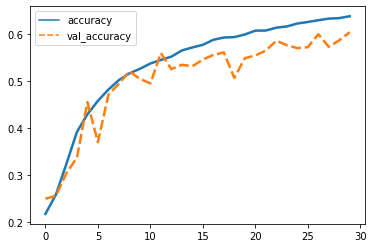

In [23]:
fit_test_save_model(model, bs=128, ep=30, fnm='fer10.json', fnw='fer10.h5')

<h3>Appliquer deuxieme fois la fonction <i style="color:blue">fit_test_save_model</i> sur le meme modele cnn</h3>
<p> Nous coyons que la performance pourrait augmenter encore apres 30 epoches car la courbe val_accuracy n'est pas stable<br>Nous allons changer deux hyperparametre <abbr title='Batch_size'><b>bs</b></abbr> et <abbr title='epochs'><b>ep</b></abbr> pour voir leur effet</p> 

Fitting the model with train set and validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/60
28709/28709 [==============================] - 1059s 37ms/step - loss: 0.9354 - accuracy: 0.6550 - val_loss: 1.0692 - val_accuracy: 0.6016
Epoch 2/60
28709/28709 [==============================] - 1056s 37ms/step - loss: 0.9271 - accuracy: 0.6549 - val_loss: 1.1080 - val_accuracy: 0.5901
Epoch 3/60
28709/28709 [==============================] - 1048s 37ms/step - loss: 0.9161 - accuracy: 0.6616 - val_loss: 1.0856 - val_accuracy: 0.5887
Epoch 4/60
28709/28709 [==============================] - 1047s 36ms/step - loss: 0.9109 - accuracy: 0.6644 - val_loss: 1.0464 - val_accuracy: 0.6027
Epoch 5/60
28709/28709 [==============================] - 1061s 37ms/step - loss: 0.9063 - accuracy: 0.6657 - val_loss: 1.1035 - val_accuracy: 0.5957
Epoch 6/60
28709/28709 [==============================] - 1050s 37ms/step - loss: 0.8971 - accuracy: 0.6684 - val_loss: 1.0412 - val_accuracy: 0.

28709/28709 [==============================] - 1054s 37ms/step - loss: 0.7479 - accuracy: 0.7271 - val_loss: 1.1154 - val_accuracy: 0.6197
Epoch 55/60
28709/28709 [==============================] - 1055s 37ms/step - loss: 0.7474 - accuracy: 0.7250 - val_loss: 1.1087 - val_accuracy: 0.6121
Epoch 56/60
28709/28709 [==============================] - 1058s 37ms/step - loss: 0.7447 - accuracy: 0.7290 - val_loss: 1.1515 - val_accuracy: 0.6085
Epoch 57/60
28709/28709 [==============================] - 1054s 37ms/step - loss: 0.7501 - accuracy: 0.7272 - val_loss: 1.0892 - val_accuracy: 0.6264
Epoch 58/60
28709/28709 [==============================] - 1055s 37ms/step - loss: 0.7339 - accuracy: 0.7319 - val_loss: 1.1602 - val_accuracy: 0.6021
Epoch 59/60
28709/28709 [==============================] - 1055s 37ms/step - loss: 0.7361 - accuracy: 0.7314 - val_loss: 1.0807 - val_accuracy: 0.6286
Epoch 60/60
28709/28709 [==============================] - 1057s 37ms/step - loss: 0.7340 - accuracy: 0.73

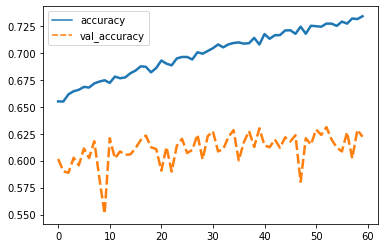

In [24]:
fit_test_save_model(model, bs=256, ep=60, fnm='fer11.json', fnw='fer11.h5')

In [27]:
show_confusion_matrix(model)

,0,1,2,3,4,5,6
0,0.62,0.03,0.13,0.04,0.09,0.02,0.07
1,0.13,0.66,0.11,0.03,0.05,0.00,0.03
2,0.08,0.02,0.62,0.04,0.09,0.12,0.03
3,0.03,0.00,0.03,0.84,0.04,0.03,0.04
4,0.12,0.01,0.22,0.06,0.44,0.02,0.13
5,0.02,0.00,0.15,0.03,0.02,0.75,0.02
6,0.11,0.00,0.10,0.06,0.19,0.03,0.49


<h3>Troisieme appliquation de la fonction <i style="color:blue">fit_test_save_model</i> sur le meme modele cnn</h3>
<p> Il est evidant que cette modele est sur-apprenti (ove-fitted)<br>
    Nous coyons vu aussi que larger batch_size (256) n'aide pas vraiment la performance<br>
    Nous allons changer deux hyperparametre <abbr title='Batch_size'><b>bs</b></abbr> et <abbr title='epochs'><b>ep</b></abbr> pour voir leur effet</p>
    Dans une direction opposee de test precedente<br>

Fitting the model with train set and validation set ...
Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 1039s 36ms/step - loss: 1.0829 - accuracy: 0.6030 - val_loss: 1.2207 - val_accuracy: 0.5539
Epoch 2/10
28709/28709 [==============================] - 1048s 37ms/step - loss: 1.0241 - accuracy: 0.6260 - val_loss: 1.2409 - val_accuracy: 0.5461
Epoch 3/10
28709/28709 [==============================] - 1033s 36ms/step - loss: 1.0051 - accuracy: 0.6304 - val_loss: 1.0652 - val_accuracy: 0.5949
Epoch 4/10
28709/28709 [==============================] - 1058s 37ms/step - loss: 1.0021 - accuracy: 0.6331 - val_loss: 1.1109 - val_accuracy: 0.5818
Epoch 5/10
28709/28709 [==============================] - 1074s 37ms/step - loss: 0.9934 - accuracy: 0.6355 - val_loss: 1.0824 - val_accuracy: 0.5993
Epoch 6/10
28709/28709 [==============================] - 1114s 39ms/step - loss: 0.9912 - accuracy: 0.6377 - val_loss: 1.0465 - val_accuracy: 0.

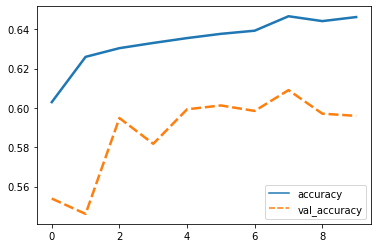

In [28]:
fit_test_save_model(model, bs=19, ep=10, fnm='fer12.json', fnw='fer12.h5')

<h3>Conclusion</h3>
<p><ol><li>Change bs et ep sur un modele deja sur-apprenti (ove-fitted) ne corrige pas la situation</li>
    <li>Utilison grand batch_size (256) a un effet tres faible sur la performance</li>
    <li>Utilison grand epoche (60) gaspille inutilement du temps si le modele est daja sur-apprenti</li>
    <li>Utilson petit batch_size (19) a un effet fort mais negative sur la performance</li>
    <li>Utilson petit batch_size (19) a un faible effet sur la vitesse d'apprentissage</li>
    <li>Bonne nouvelle est que Accuracy Test global se monte a 62%</li>
    <li>Accuracy Test pour la categorie 3 (happy), echantillons le plus grande, se monte a 84%</li>
    <li>Suivi par la categorie 5 (surprise), avec Accuracy Test 75%</li>
    <li>Accuracy Test pour la categorie 1 (disgust), echantillons le plus petit, 66%, n'est pas la plus faible</li>
    <li>Le plus faible Accuray Test: 44% se trouve pour la categorie 4 (sad)</li>
    

## Une autre version, que j'espere un performance plus elevee, viendra sous peu